### Copy for Landsat 8. Guetting modified
### 15-Nov-2018 New way of procecessing Sentinel 2A data to dNBR
***
1. [rasterio](https://anaconda.org/conda-forge/rasterio) version = 1.0.11
2. new resampling methode should be adopted along with other modifications
3. we base the new code on the "L2AResaml_Subset_Create2NBR_dNBR_dNBR7class_&_Masked_itWorks-Nodata-Copy1" notebook
***
- Why not to stack the input bands in order to add quality band for cloud masking 

In [1]:
import rasterio, os, pprint, zipfile, re, fiona, tarfile
from rasterio import Affine
import rasterio.mask
from rasterio.warp import calculate_default_transform, reproject, Resampling 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import earthpy.spatial as es


# Extarct the S2A bands from Zip, Resample to 30m then save to tif

In [2]:
#wrkdir='..\\data'
wrkdir='../data2'
#rsltdir='..\\resultS2A'
rslts2a = '../rsltS2A'
rsltlc8 = '../rsltLC8'
# thezip='zip://'
# tifbands='tifbands'
posProcessdir='/media/mustapha/Seagate/NBRproject/posProcess'

In [3]:
def rasterStack (list_to_stack, output_stack):
    """
    list_to_stack: Sorted band's path with the same dtype and extend
    output_stack: stack output path
    shapefile: path to file.shp
    """
#     list_lenght = len(list_to_stack)
#     assert list_lenght==3, 'the bands_list lenght  is {}, it has to be 3 '.format(list_lenght)
    
    # Read metadata of first file
    with rasterio.open(list_to_stack[0]) as src0:
        meta = src0.profile
                
    # Update meta due to stacking
    meta.update({"count": len(list_to_stack) })  #set the number of stack layers
    
    # Read each layer and write it to stack
    with rasterio.open(output_stack, 'w', **meta) as dst:
        for id, layer in enumerate(list_to_stack, start=1):
            with rasterio.open(layer) as src1:
                dst.write_band(id, src1.read(1))

### Cloud masking

In [4]:
def clMaskValues(sat):
    
    if sat=='S2A':
        #scl s2a vlaues: 0:NO_DATA, 1: SATURATED-OR-DEFFECTIVE; 2:DARK-AREA-PIXELS
        #3:CLOUD_SHADOWS, 4:VEGETATION, 5:NOT_VEGETATED, 6:WATER, 7:UNCLASSIFIED
        #8:CLOUD_MEDIUM_PROBABILITY, 9:CLOUD_HIGH_PROBABILITY, 10:THIN_CIRRUS, 11:SNOW
        valuestomask= [0,1,2,3,8,9,10,11]
    elif sat=='LC8':
        fill = [1]
#         clear_land = [322, 386, 834, 898, 1346]
#         clear_water = [324, 388, 836, 900, 1348]
        cloud_shadow = [328, 392, 840, 904, 1350]
        snow_ice = [336, 368, 400, 432, 848, 880, 912, 944, 1352]
        cloud = [352, 416, 480, 864, 928, 992]
        valuestomask = fill+cloud_shadow+snow_ice+cloud
    return valuestomask

In [5]:
def cloudMaskedName(path):
    basename = os.path.basename(path)
    nsplit = basename.split('.')
    cmname ='.'.join(('_'.join((nsplit[0],'cm')),nsplit[1]))
    return os.path.join(os.path.dirname(path),cmname)
# name=  '../result2_S2A/prtoct18/20180907/S2A_prtoct18_T29SMC_20180907_B8A.tif'
# cloudMaskedName(name)

In [6]:
def rasterCloudMask(inband, mask_band, sat):
    """ inband: band to mask
        mask_band: band cntaining the the masking value. i.e. quaity band
        outband: path to the output band
        sat: satellite used. S2A by default
    """
    #read quality band 
    with rasterio.open(mask_band,'r') as src_qb:
        qband=src_qb.read(1)
        
    #read band to mask     
    with rasterio.open(inband, 'r') as src_inb:
        src_arr = src_inb.read(1,masked=True)

        meta= src_inb.profile
#         print('CLOUD MASKING input band profile \n', meta)
        #         meta.update({'dtype':'uint16'}) #removed for landsat8 
            
    #list of values to mask. source: SCL band for S2A
    #calling clMaskValues function
    valuestomask = clMaskValues(sat)
    #create umpty array mask
    cl_mask = np.zeros(qband.shape)
    
    #assign value one to the mask array where Valuestomask contain the listed values
    for value in valuestomask:
        cl_mask[qband == value] = 1
    
    #create array with the shape of the raster input. One band in this case    
    pre_mask = np.broadcast_to(cl_mask == 1, src_arr.shape)

    #mask the the wanted array using the pre_mask
    src_arr_cl_free = np.ma.masked_array(src_arr, mask=pre_mask)

    #assign 0 value to masked value
    arr_with_None = np.where(cl_mask == 0, src_arr_cl_free, 0)
    
    #calling cloudMaskedName function
    outband = cloudMaskedName(inband)
    #write the masked band as raster
    with rasterio.open(outband, 'w', **meta) as dst:
#         dst.write_band(1,arr_with_None.astype(rasterio.uint16)) #modified for landsat8
        dst.write_band(1,arr_with_None.astype(rasterio.uint16))
    return outband
    

### NBR 

In [7]:
def nbrName(nir, swir):
    nirbase = os.path.basename(nir)
    swirbase = os.path.basename(swir)
    ns  = nirbase.split('.')[0].split('_')
    ss = swirbase.split('.')[0].split('_')
    nbrname = '.'.join(('_'.join((ns[0],ns[1],ns[2],ns[3],ns[4],ss[4],ns[5],'nbr')),nir.split('.')[-1]))
    return os.path.join(os.path.dirname(nir),nbrname)

# nir = '../result2_S2A/prtoct18/20180907/S2A_prtoct18_T29SMC_20180907_B8A_cm.tif'
# swir = '../result2_S2A/prtoct18/20180907/S2A_prtoct18_T29SMC_20180907_B12_cm.tif'
# nbrName(nir, swir)

In [8]:
def NBRfuncion(NIRband,SWIRband):
    '''
    expecting three band paths, NIR, SWIR and the output (NBR)
    '''
    with rasterio.open(NIRband) as srcNIR:        
        NIRarr=srcNIR.read()
#         pprint.pprint(srcNIR.meta)
        with rasterio.open(SWIRband) as srcSWIR:
            SWIRarr = srcSWIR.read()
#             pprint.pprint(srcSWIR.meta)
            np.seterr(divide='ignore', invalid='ignore')            
            NBRarr = (NIRarr.astype(float) - SWIRarr.astype(float)) / (NIRarr + SWIRarr)
#             NBRarr = NBRarr.astype('float32')
            meta = srcSWIR.profile.copy()
            meta.update({'dtype': rasterio.float32}) #this maybe changed in the future !! have to think about it
#             pprint.pprint(meta)
            
            nbrband = nbrName(NIRband,SWIRband)
            with rasterio.open(nbrband,'w', **meta) as dst:
                dst.write(NBRarr.astype(rasterio.float32))
#                 pprint.pprint(dst.profile)
#             print('end NBRfunction')
    return nbrband

### dNBR

In [52]:
def dNBRName(prepath, pospath):
    prepathbase = os.path.basename(prepath)
    pospathbase = os.path.basename(pospath)
    presplit= prepathbase.split('.')[0].split('_')
    possplit= pospathbase.split('.')[0].split('_')
    
    dNBRname = '.'.join(('_'.join((presplit[0],presplit[1],presplit[2],presplit[3],possplit[3],presplit[6],'dNBR')),prepathbase.split('.')[-1]))

    newdir ='/'.join(prepath.split('/')[:-2])
    
    dNBRnewname=os.path.join(newdir,dNBRname)
    
    return dNBRnewname
pre = '../result2_S2A/prtoct18/20180907/S2A_prtoct18_T29SMC_20180907_B8A_B12_cm_nbr.tif'
pos = '../result2_S2A/prtoct18/20181007/S2A_prtoct18_T29SMC_20181007_B8A_B12_cm_nbr.tif'
dNBRName(pre,pos)

'../result2_S2A/prtoct18/S2A_prtoct18_T29SMC_20180907_20181007_cm_dNBR.tif'

In [53]:
def dNBRfunction(preNBR, posNBR):
    '''
    preNBR: input path
    posNBR: input path
    newdir: output path
    '''
    with rasterio.open(preNBR) as srcPRE:        
        PREarr=srcPRE.read(1, masked=True)
#         print(PREarr.dtype)
#         print(srcPRE.profile)
#         print(PREarr[3000:3100,3000:3100])
#         print(PREarr.mask)
        with rasterio.open(posNBR) as srcPOS:
            POSarr=srcPOS.read(1, masked=True)
#             print(POSarr.dtype)
#             print(srcPOS.profile)
            dNBRarr = (PREarr.astype(float) - POSarr.astype(float)) # don't force to be float. it is already float 32
            
            meta = srcPRE.meta.copy()
            meta.update({'dtype': rasterio.float32})
            #create outputname
            dNBR = dNBRName(preNBR, posNBR)
#             print('created dNBR', dNBR)

            with rasterio.open(dNBR,'w', **meta) as dst:
                dst.write_band(1,dNBRarr.astype(rasterio.float32))
#                 pprint.pprint(dst.profile)
    return dNBR
# pre= '../rsltLC8/prtoct18/20180922/LC8_prtoct18_204033_20180922_band5_band7_cm_nbr.tif'
# pos= '../rsltLC8/prtoct18/20181008/LC8_prtoct18_204033_20181008_band5_band7_cm_nbr.tif'
# dNBRfunction(pre,pos)

### Reclassification - fire severity

In [54]:
def reclassBandName(path):
    basename = os.path.basename(path)
    subname ='.'.join(('_'.join((basename.split('.')[0],'7class')),basename.split('.')[-1]))
    return os.path.join(os.path.dirname(path),subname)

In [79]:
def dNBRreclass(dNBR):
    '''
    this function reclassifies the dNBR
    '''
    with rasterio.open(dNBR) as src:
        arr = src.read(1, masked=True)
        #reclassification
        arr[                 (arr < -0.25)] = 11
        arr[(-0.25 <= arr) & (arr < -0.10)] = 12
        arr[(-0.10 <= arr) & (arr <  0.10)] = 13
        arr[( 0.10 <= arr) & (arr <  0.27)] = 14
        arr[( 0.27 <= arr) & (arr <  0.44)] = 15
        arr[( 0.44 <= arr) & (arr <  0.66)] = 16
        arr[( 0.66 <= arr) & (arr <= 3.00)] = 17
        arr[arr==11]=1; arr[arr==12]=2; arr[arr==13]=3; arr[arr==14]=4; arr[arr==15]=5; arr[arr==16]=6; arr[arr==17]=7        
        #update metadata
        meta = src.profile.copy()
        meta.update({'dtype': rasterio.uint8,
                    'nodata': 0})
        #calling reclass bands
        dNBR7class = reclassBandName(dNBR)
        with rasterio.open(dNBR7class,'w', **meta) as dst:
            dst.write_band(1,arr.astype(rasterio.uint8))
#             pprint.pprint(dst.profile)
    return dNBR7class
band_='../rsltLC8/prtoct18/LC8_prtoct18_204033_20180922_20181008_cm_dNBR.tif'
reclass_band_=dNBRreclass(band_)
reclass_band_


'../rsltLC8/prtoct18/LC8_prtoct18_204033_20180922_20181008_cm_dNBR_7class.tif'

### sr band name listing

In [56]:
def srBandsNameList(Sat, sourcefile):
    """ 
    Input
    Sat: S2A or LC8
    sourcefile: zipfile or tar_file
    Return list of band names
    """
    if Sat=='S2A':
        B8Agrep = re.compile('.*(B8A_20m).jp2$')
        B12grep = re.compile('.*(B12_20m).jp2$')
        SCLgrep = re.compile('.*(SCL_20m).jp2$')
        B8Aband = list(filter(lambda x: B8Agrep.search(x),sourcefile.namelist()))[0]   
        B12band = list(filter(lambda x: B12grep.search(x),sourcefile.namelist()))[0]
        SCLband = list(filter(lambda x: SCLgrep.search(x),sourcefile.namelist()))[0]
        return [B8Aband,B12band,SCLband]
    elif Sat=='LC8':
        b5grep = re.compile('.*_sr_band5.tif$')
        b7grep = re.compile('.*_sr_band7.tif$')
        qbgrep = re.compile('.*_pixel_qa.tif$')
        band5  = list(filter(lambda x: b5grep.search(x),sourcefile.getnames()))[0]
        band7  = list(filter(lambda x: b7grep.search(x),sourcefile.getnames()))[0]
        qband  = list(filter(lambda x: qbgrep.search(x), sourcefile.getnames()))[0]  
        return [band5,band7,qband]

In [101]:
def srBandsNewNameList(Sat,firename, scene):
    if   Sat == 'S2A':
        try:
            tile, date, band= re.match(r'(T.{5})_(\d{8})T\d{6}_(B.{2}|SCL)_\d{2}m.jp2', scene).groups()
        except:
            tile, date, band= re.match(r'L2A_(T.{5})_(\d{8})T\d{6}_(B.{2}|SCL)_\d{2}m.jp2', scene).groups()
        print(tile,date,band)
    elif Sat == 'LC8':
        try:
            tile, date, band = re.match(r'LC08_L1TP_(\d{6})_(\d{8})_\d{8}_01_T1_sr_(.*)\.tif$',scene).groups()
        except:
            tile, date, band = re.match(r'LC08_L1TP_(\d{6})_(\d{8})_\d{8}_01_T1_pixel_(qa)\.tif$',scene).groups()
    band_new_name = '.'.join(('_'.join((Sat,firename,tile,date,band)),'tif'))
    return (band_new_name, date)


### Clip functions

In [102]:
# def aoiList(path):
#     shpgrep = re.compile('.*\.shp$')
#     shplist = list(filter(lambda x: shpgrep.search(x),os.listdir(path)))
#     return shplist
# aoiList('../data3/proenca20170922')

In [103]:
# def clipBandName1(path):
#     """
#     single aoi
#     path: band path
#     """
#     basename = os.path.basename(path)
#     subname ='.'.join(('_'.join((basename.split('.')[0],'sub')),basename.split('.')[-1]))
#     return os.path.join(os.path.dirname(path),subname)

In [104]:
def clipBandName2(band,aoi):
    """
    New naming for multiple fire per image 
    band:
    aoi: i.e. firenamedate_aoi01.shp. the "aoi01" will be used in the fire name
    """
    baseband = os.path.basename(band)
    baseaoi = os.path.basename(aoi)
    subaoi=baseaoi.split('.')[0].split('_')[-1]
    print(subaoi)
    subname ='.'.join(('_'.join((baseband.split('.')[0],subaoi)),baseband.split('.')[-1]))
    #postprocessing directory
    pp_dir = ''.join((baseband.split('.')[0].split('_')[1],subaoi))
        
    return (pp_dir,subname)

In [105]:
def rasterClip(inband,aoi,dstsub):
    '''
    inband: band to clip
    aoi: AOI
    dst: destination directory
    '''        
    
    with fiona.open(aoi) as srcV:
    #     pprint.pprint(src3[0]["geometry"])
        features = [feature["geometry"] for feature in srcV]
        srcV_crs = srcV.crs
#         print('vector',srcV_crs)
        with rasterio.open(inband) as srcR:
            srcR_crs = srcR.crs.to_dict()

            assert srcV_crs == srcR_crs

    #         print('raster:', srcR_crs)
            out_image, out_transform = rasterio.mask.mask(srcR, features, crop=True)
            out_meta = srcR.meta.copy() 

            out_meta.update({"driver": "GTiff",
                             "height": out_image.shape[1],
                             "width": out_image.shape[2],
                             "transform": out_transform})

            
            with rasterio.open(dstsub, "w", **out_meta) as dst:
                dst.write(out_image)
                plt.imshow(out_image[0])

    return dstsub

In [106]:
def clipMultiple(band,srcdir,dstdir):
    """
    band: band to clip
    aoilist: list of aoi
    dstdir: postprocessing dir
    """
    aoigrep = re.compile('.*\.shp$')
    aoilist = list(filter(lambda x: aoigrep.search(x),os.listdir(os.path.join(srcdir))))
    assert len(aoilist) >= 1, 'No aoi in the directory'
    for aoi in aoilist:
        
        #create sub dst path
        pp_dir, subname = clipBandName2(band,aoi)
        
        if not os.path.exists(os.path.join(dstdir,pp_dir)):
            os.makedirs(os.path.join(dstdir,pp_dir))
        dstsub = os.path.join(dstdir,pp_dir,subname)
        #clip
        aoipath=os.path.join(srcdir,aoi)
        rasterClip(band,aoipath,dstsub)
        

### S2A functions

In [107]:
def s2aResample(inputpath, outputpath,res='30'):
    '''
    inputpath : bands path. in this case it's the path of the band inside the Zipfile
                'zip://data/files.zip!RGB.byte.jp2'
    outputpath: 
    res: str indicating the output resolution 
          i.e. res='30'  for 30m resolution   
    '''
    with rasterio.open(inputpath,'r') as src:
        src_arr = src.read()
#         print('RESAMPLING input jp2 profile \n', src.profile)
        new_resolution = (int(res),int(res))

        new_transform, new_width, new_height = calculate_default_transform(src.crs, src.crs,
                                                                           src.width, src.height,
                                                                           *src.bounds,
                                                                           resolution=new_resolution)

        #creating a empty contener for the 30m resolution S2A raster    
        dst_arr = np.zeros(shape=(src_arr.shape[0],
                                  new_width,
                                  new_height), dtype=np.uint16)
        #update metadata
        meta = src.profile.copy()
        meta.update({'transform': new_transform,
                     'width' : new_width,
                     'height': new_height,
                     'nodata': 0,
                     'driver': 'GTiff',
                     'dtype' : 'uint16'})
#                      'tiled': True,
#                      'blockxsize': 256,
#                      'blockysize': 256,
#                      'photometric': 'YCbCr',
#                      'compress':'JPEG' })   #'affine':new_transform, was removed
        
#         print('RESAMPLING output tif profile \n', meta)
        reproject(src_arr, dst_arr,
                  src_transform=src.transform,
                  dst_transform=new_transform,
                  width=new_width,
                  height=new_height,
                  src_nodata=src.nodata,
                  dst_nodata=0,
                  src_crs=src.crs,# no change in the CRS
                  dst_crs=src.crs,
                  resample=Resampling.average) 
        
        #creating mask where data == 0
        dst_arr = np.ma.masked_where(dst_arr==0,dst_arr)
        dst_arr.set_fill_value(0)
        
        with rasterio.open(outputpath,'w', **meta) as dst:
            dst.write(dst_arr.astype(rasterio.uint16))

In [108]:
def unarchiveS2ABands(s2azipdir, Sat='S2A'):
    """
    return: list of the resampled and saved S2A bands
    """
    
    with zipfile.ZipFile(s2azipdir, 'r') as zip_file:

        #calling srBandsNameList function
        s2a_bands_list = srBandsNameList(Sat, zip_file)
        
        #umpty band list for stacking
        list_extracted_bands=[]

        for bandpath in s2a_bands_list:
            #Input path for rasterio (Apache path style 'zip://dir/file.zip!bandpath)
            thezip='zip://'
            jp2bandpath=thezip+s2azipdir+'!/'+bandpath
        
           #calling srBandsNewNameList function
            band_new_name,datetxt =srBandsNewNameList(Sat,cntr, os.path.basename(jp2bandpath))
            
            if not os.path.exists(os.path.join(rslts2a,cntr,datetxt)):
                os.makedirs(os.path.join(rslts2a,cntr,datetxt))
            
            tifbandpath = os.path.join(rslts2a,cntr,datetxt,band_new_name)
            print(tifbandpath)

            #calling the s2aResample function
            s2aResample(jp2bandpath, tifbandpath) #calling the s2aResample function
            #create list of extracted band paths in the destination directory
            list_extracted_bands.append(tifbandpath)   
            
#             #cliping the resampled raster band
#             rasterClip(tifbandpath,aoiPath)
            srcdir = os.path.join(wrkdir,cntr)
            clipMultiple(tifbandpath,srcdir,posProcessdir)
        
    return list_extracted_bands

### Main S2A

list of fire cases ['prtped', 'prtps2', 'prtsin']
PROCESSSING prtped
prtped
['S2A_MSIL2A_20170604T112121_N0205_R037_T29TNE_20170604T112755.zip', 'S2A_MSIL2A_20170704T112111_N0205_R037_T29TNE_20170704T112431.zip']
T29TNE 20170604 B8A
../rsltS2A/prtped/20170604/S2A_prtped_T29TNE_20170604_B8A.tif
aoi01
T29TNE 20170604 B12
../rsltS2A/prtped/20170604/S2A_prtped_T29TNE_20170604_B12.tif
aoi01
T29TNE 20170604 SCL
../rsltS2A/prtped/20170604/S2A_prtped_T29TNE_20170604_SCL.tif
aoi01
list_extracted_bands ['../rsltS2A/prtped/20170604/S2A_prtped_T29TNE_20170604_B8A.tif', '../rsltS2A/prtped/20170604/S2A_prtped_T29TNE_20170604_B12.tif', '../rsltS2A/prtped/20170604/S2A_prtped_T29TNE_20170604_SCL.tif']
aoi01
aoi01
aoi01
T29TNE 20170704 B8A
../rsltS2A/prtped/20170704/S2A_prtped_T29TNE_20170704_B8A.tif
aoi01
T29TNE 20170704 B12
../rsltS2A/prtped/20170704/S2A_prtped_T29TNE_20170704_B12.tif
aoi01
T29TNE 20170704 SCL
../rsltS2A/prtped/20170704/S2A_prtped_T29TNE_20170704_SCL.tif
aoi01
list_extracted_bands ['.

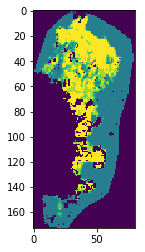

In [109]:
cntrlist = [ name for name in os.listdir(wrkdir) if os.path.isdir(os.path.join(wrkdir, name)) ]
print('list of fire cases',cntrlist)
for cntr in cntrlist:
    print('PROCESSSING', cntr)
#     if not os.path.exists(os.path.join(rsltdir,cntr)):
#         os.makedirs(os.path.join(rsltdir,cntr))
   
#     # defining the shp file path
#     shpgrep = re.compile('.*.shp')
#     shplist = filter(lambda x: shpgrep.search(x),os.listdir(os.path.join(wrkdir,cntr)))
#     shpfile = list(shplist)[0]
#     aoiPath = os.path.join(wrkdir,cntr,shpfile)
#     print(aoiPath)
    print(cntr)
    ### S2A 
    # listing the zip file path
    s2agrep=re.compile('S2A.*\.zip$')
    s2aziplist= list(filter(lambda x: s2agrep.search(x),os.listdir(os.path.join(wrkdir,cntr))))
    print(s2aziplist)
    if len(s2aziplist) == 0:
        continue
    assert len(s2aziplist)== 2, 'list of s2a zip archive must be equal to 2'
    #umpty list of NBR bands
    
    list_nbr_bands=[]
    
    for s2azip in s2aziplist:
        
        s2azipdir = os.path.join(wrkdir,cntr,s2azip)
        
        #calling unarchiveS2ABands function
        list_extracted_bands = unarchiveS2ABands(s2azipdir)
        print('list_extracted_bands', list_extracted_bands)
         
        #cloud masking
        list_clmasked_bands=[]
        for band in list_extracted_bands[:2]:
            
            #calling the cloud masking function
            cmband = rasterCloudMask(band,list_extracted_bands[-1],'S2A')
            #update cloud masked band list
            list_clmasked_bands.append(cmband)
            
            #clip cloud masked bands
#             rasterClip(cmband, aoiPath)
            srcdir = os.path.join(wrkdir,cntr)
            clipMultiple(cmband,srcdir,posProcessdir)
        #calling the NBRfunction        
        nbrband = NBRfuncion(list_clmasked_bands[0],list_clmasked_bands[1])
        #update nbr band list
        list_nbr_bands.append(nbrband)
        
        #clip nbr bands
#         rasterClip(nbrband, aoiPath)
        srcdir = os.path.join(wrkdir,cntr)
        clipMultiple(nbrband,srcdir,posProcessdir)
#         
    #calling dNBR function
    list_nbr_bands.sort
    pprint.pprint(list_nbr_bands)
    
    dNBRband = dNBRfunction(list_nbr_bands[0], list_nbr_bands[1])   
    #clip dNBR band
    srcdir = os.path.join(wrkdir,cntr)
    clipMultiple(dNBRband,srcdir,posProcessdir)
    
    #calling the dNBR reclassification function
    print('dNBRband', dNBRband)
    dNBRrecl = dNBRreclass(dNBRband)

    #calling rasterClip function
    srcdir = os.path.join(wrkdir,cntr)
    clipMultiple(dNBRrecl,srcdir,posProcessdir)

print('Process ended successfully')

### LC8 functions

In [95]:
def lc8Update (lc8,lc8update):
    """
    Harmonize lc8 arr values with s2a
    """
    with rasterio.open(lc8) as src:
        lc8arr = src.read(1, masked=True)

        print(src.profile)
        meta=src.profile
        meta.update({'nodata':0, 'dtype':'uint16'})

        #negative values and assign to 0
        lc8arr[lc8arr<0]=0
        #mask value 0
        lc8arr = np.ma.masked_where(lc8arr==0,lc8arr)
        lc8arr.set_fill_value(0)

        with rasterio.open(lc8update, 'w',**meta) as dst:
            dst.write_band(1,lc8arr.astype(rasterio.uint16))

    return lc8update

In [96]:
def unarchiveLC8Bands(lc8targzarchive,dst_dir):
    """ extracting the LC8 bands
    lc8targzarchive: lc8  tar archive
    extractdir: directory to extract to
    return:     sr_nbr.tif and _pixel_qa.tif
    """
    # open tar file
    tar_file = tarfile.open(lc8targzarchive,'r') #open tarfile
    
    #calling srBandsNameList function
    lc8_bands_list = srBandsNameList('LC8', tar_file)
    print(lc8_bands_list)
#     nbrpath = os.path.join(extrcatdir,nbrband)
#     qbpath  = os.path.join(extrcatdir,qband)
    for band in lc8_bands_list:
    
        #start the extraction
        tar_file.extract(band, path=dst_dir)
    tar_file.close()# close tarfile
    list_new_names=[]
    for band in lc8_bands_list:
        #rename landsat bands 
        band_new_name,datetxt = srBandsNewNameList('LC8',cntr,band)
        
        #create date directory
        if not os.path.exists(os.path.join(rsltlc8,cntr,datetxt)):
                os.makedirs(os.path.join(rsltlc8,cntr,datetxt))
        #rename and relocate the file with lc8 new parameters
        lc8updated = os.path.join(dst_dir,datetxt,band_new_name)
        
        #calling the lc8Update function
        extractedlc8band = os.path.join(rsltlc8,cntr,band)
        lc8Update (extractedlc8band,lc8updated)
        os.remove(os.path.join(dst_dir,band))
        list_new_names.append(lc8updated)

        #clip lc8 band
#         rasterClip(lc8updated,aoiPath)
        srcdir = os.path.join(wrkdir,cntr)
        clipMultiple(lc8updated,srcdir,posProcessdir)
        
    return list_new_names
    

### Main LC8

PROCESSSING prtped
PROCESSSING prtps2
PROCESSSING prtps3
PROCESSSING prtsin
['LC08_L1TP_204033_20180922_20180928_01_T1_sr_band5.tif', 'LC08_L1TP_204033_20180922_20180928_01_T1_sr_band7.tif', 'LC08_L1TP_204033_20180922_20180928_01_T1_pixel_qa.tif']
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS({'init': 'epsg:32629'}), 'transform': Affine(30.0, 0.0, 395985.0,
       0.0, -30.0, 4423515.0), 'tiled': False, 'interleave': 'band'}
aoi01
{'driver': 'GTiff', 'dtype': 'int16', 'nodata': -9999.0, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS({'init': 'epsg:32629'}), 'transform': Affine(30.0, 0.0, 395985.0,
       0.0, -30.0, 4423515.0), 'tiled': False, 'interleave': 'band'}
aoi01
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 1.0, 'width': 7731, 'height': 7851, 'count': 1, 'crs': CRS({'init': 'epsg:32629'}), 'transform': Affine(30.0, 0.0, 395985.0,
       0.0, -30.0, 4423515.0), 'tiled': False, 'interleave': 'band'}
aoi01

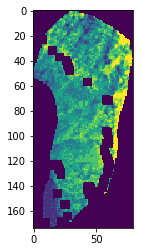

In [99]:
cntrlist = [ name for name in os.listdir(wrkdir) if os.path.isdir(os.path.join(wrkdir, name)) ]
# print(cntrlist[0])
for cntr in cntrlist:
    print('PROCESSSING', cntr)
#     if not os.path.exists(os.path.join(rsltdir,cntr)):
#         os.makedirs(os.path.join(rsltdir,cntr))
   
    # defining the shp file path
#     aoigrep = re.compile('.*\.shp$')
#     aoilist = list(filter(lambda x: aoigrep.search(x),os.listdir(os.path.join(wrkdir,cntr))))
    
    if not os.path.exists(os.path.join(rsltlc8,cntr)):
        os.makedirs(os.path.join(rsltlc8,cntr))  
    # defining the tar file path
    lc8targzgrep = re.compile('LC08.*\.tar.gz$')
    lc8targzlist = list(filter(lambda x: lc8targzgrep.search(x),os.listdir(os.path.join(wrkdir,cntr))))
    #define the output directory
#     extractdir=os.path.join(rsltlc8,cntr)
    if len(lc8targzlist) == 0:
        continue
        
    #umpty list of NBR bands
    list_nbr_bands=[]
    
    for lc8targz in lc8targzlist:
        lc8targzarchive = os.path.join(wrkdir,cntr,lc8targz)
        dst_dir = os.path.join(rsltlc8,cntr)
        # open tar file
        list_extracted_bands = unarchiveLC8Bands(lc8targzarchive,dst_dir)
                #cloud masking
        list_clmasked_bands=[]

        for band in list_extracted_bands[:2]:
            
            #calling the cloud masking function
            cmband = rasterCloudMask(band,list_extracted_bands[-1],'LC8')
            #update cloud masked band list
            list_clmasked_bands.append(cmband)
            
            #clip cloud masked bands
#             rasterClip(cmband, aoiPath)
            srcdir = os.path.join(wrkdir,cntr)
            clipMultiple(cmband,srcdir,posProcessdir)
        #calling the NBRfunction        
        nbrband = NBRfuncion(list_clmasked_bands[0],list_clmasked_bands[1])
        #update nbr band list
        list_nbr_bands.append(nbrband)
        
        #clip nbr bands
#         rasterClip(nbrband, aoiPath)
        srcdir = os.path.join(wrkdir,cntr)
        clipMultiple(nbrband,srcdir,posProcessdir)
#         
    #calling dNBR function
    list_nbr_bands.sort
    pprint.pprint(list_nbr_bands)
    
    dNBRband = dNBRfunction(list_nbr_bands[0], list_nbr_bands[1])   
    #clip dNBR band
    srcdir = os.path.join(wrkdir,cntr)
    clipMultiple(dNBRband,srcdir,posProcessdir)
    
    #calling the dNBR reclassification function
    print('dNBRband', dNBRband)
    dNBRrecl = dNBRreclass(dNBRband)

    #calling rasterClip function
    srcdir = os.path.join(wrkdir,cntr)
    clipMultiple(dNBRrecl,srcdir,posProcessdir)

print('Process ended successfully')

#### next steps
- list bands to stack
- stack
- mask cloud
- maybe put all bands in pre and post folders

In [ ]:
a=[1,2]

In [ ]:
len(a)